# Importing The Necessary Dependencies

In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from PIL import Image
import glob
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from PIL import Image

# Loading and Splitting The Data

In [2]:
images = glob.glob("DATA++\\Mass\\*_FULL_*.png")
mask = glob.glob("DATA++\\Mass\\*_MASK_*.png")

In [3]:
print(images[:5])
print('-------------------')
print(mask[:5])

['DATA++\\Mass\\Mass-Test_P_00016_LEFT_CC_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00016_LEFT_MLO_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_CC_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_MLO_FULL_PRE.png', 'DATA++\\Mass\\Mass-Test_P_00032_RIGHT_CC_FULL_PRE.png']
-------------------
['DATA++\\Mass\\Mass-Test_P_00016_LEFT_CC_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00016_LEFT_MLO_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_CC_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00017_LEFT_MLO_MASK_1___PRE.png', 'DATA++\\Mass\\Mass-Test_P_00032_RIGHT_CC_MASK_1___PRE.png']


In [4]:
data = pd.DataFrame({'images':images,'masks':mask})
data.head(9)

,images,masks
0,DATA++\Mass\Mass-Test_P_00016_LEFT_CC_FULL_PRE...,DATA++\Mass\Mass-Test_P_00016_LEFT_CC_MASK_1__...
1,DATA++\Mass\Mass-Test_P_00016_LEFT_MLO_FULL_PR...,DATA++\Mass\Mass-Test_P_00016_LEFT_MLO_MASK_1_...
2,DATA++\Mass\Mass-Test_P_00017_LEFT_CC_FULL_PRE...,DATA++\Mass\Mass-Test_P_00017_LEFT_CC_MASK_1__...
3,DATA++\Mass\Mass-Test_P_00017_LEFT_MLO_FULL_PR...,DATA++\Mass\Mass-Test_P_00017_LEFT_MLO_MASK_1_...
4,DATA++\Mass\Mass-Test_P_00032_RIGHT_CC_FULL_PR...,DATA++\Mass\Mass-Test_P_00032_RIGHT_CC_MASK_1_...
5,DATA++\Mass\Mass-Test_P_00032_RIGHT_MLO_FULL_P...,DATA++\Mass\Mass-Test_P_00032_RIGHT_MLO_MASK_1...
6,DATA++\Mass\Mass-Test_P_00037_RIGHT_CC_FULL_PR...,DATA++\Mass\Mass-Test_P_00037_RIGHT_CC_MASK_1_...
7,DATA++\Mass\Mass-Test_P_00037_RIGHT_MLO_FULL_P...,DATA++\Mass\Mass-Test_P_00037_RIGHT_MLO_MASK_1...
8,DATA++\Mass\Mass-Test_P_00056_LEFT_MLO_FULL_PR...,DATA++\Mass\Mass-Test_P_00056_LEFT_MLO_MASK_1_...


In [5]:
data.shape

(1592, 2)

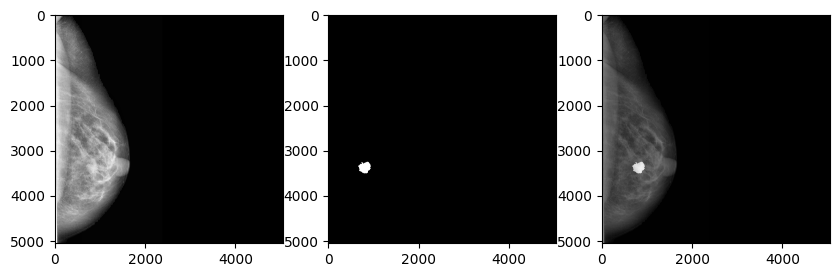

In [8]:
import cv2 
N=18
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
img=cv2.imread(data.images.iloc[N])
plt.imshow(img)
plt.subplot(1,3,2)
msk=cv2.imread(data.masks.iloc[N])
plt.imshow(msk)
plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(msk,alpha=0.5)

In [6]:
data_train,data_test=train_test_split(data,test_size=0.1)

data_train,data_val=train_test_split(data_train,test_size=0.2)

In [7]:
datagen = ImageDataGenerator(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest',
                            rescale=1./255)

In [8]:
image_train=datagen.flow_from_dataframe(data_train,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=8,
                                    class_mode=None
                                    
)
mask_train=datagen.flow_from_dataframe(data_train, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=8,
                                    class_mode=None
)

Found 1145 validated image filenames.
Found 1145 validated image filenames.


In [9]:
image_validation=datagen.flow_from_dataframe(data_val,  
                                    target_size=(256,256), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="images", 
                                    batch_size=8,
                                    class_mode=None
)

mask_validation=datagen.flow_from_dataframe(data_val, 
                                    target_size=(256,256), 
                                    color_mode='grayscale',
                                    shuffle=True,
                                    seed=123,
                                    x_col ="masks", 
                                    batch_size=8,
                                    class_mode=None
)

Found 287 validated image filenames.
Found 287 validated image filenames.


In [10]:
train_gen=zip(image_train,mask_train)
valid_gen=zip(image_validation,mask_validation)

# Building The Model

In [11]:
def unet(input_size=(256,256,3)):
    inputs = layers.Input(input_size)
            
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = layers.BatchNormalization(axis=3)(conv1)
    bn1 = layers.Activation('relu')(bn1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = layers.BatchNormalization(axis=3)(conv2)
    bn2 = layers.Activation('relu')(bn2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = layers.BatchNormalization(axis=3)(conv3)
    bn3 = layers.Activation('relu')(bn3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = layers.BatchNormalization(axis=3)(conv4)
    bn4 = layers.Activation('relu')(bn4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = layers.BatchNormalization(axis=3)(conv5)
    bn5 = layers.Activation('relu')(bn5)

    up6 = layers.concatenate([layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = layers.BatchNormalization(axis=3)(conv6)
    bn6 = layers.Activation('relu')(bn6)

    up7 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = layers.BatchNormalization(axis=3)(conv7)
    bn7 = layers.Activation('relu')(bn7)

    up8 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = layers.Activation('relu')(conv8)
    conv8 = layers.Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = layers.BatchNormalization(axis=3)(conv8)
    bn8 = layers.Activation('relu')(bn8)

    up9 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = layers.Activation('relu')(conv9)
    conv9 = layers.Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = layers.BatchNormalization(axis=3)(conv9)
    bn9 = layers.Activation('relu')(bn9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return models.Model(inputs=[inputs], outputs=[conv10])

In [12]:
smooth=1
def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

In [13]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=50)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint_256.h5', monitor='val_dice_coef', save_best_only=True)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=5)

In [14]:
model = unet(input_size=(256, 256, 3))

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 32, 32, 1024  0           ['conv2d_transpose[0][0]',       
                                )                                 'conv2d_7[0][0]']               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 512)  4719104     ['concatenate[0][0]']            
                                                                                                  
 activation_10 (Activation)     (None, 32, 32, 512)  0           ['conv2d_10[0][0]']              
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 512)  2359808     ['activation_10[0][0]']          
          

In [16]:
model.compile(
    optimizer='adam',
    loss=bce_dice_loss,
    metrics=[dice_coef,'accuracy'])

In [17]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=60,
    validation_steps=len(data_val) /8,
    steps_per_epoch=len(data_train) /8,
    callbacks=[early_stopping_callback,checkpoint_callback,reduce_lr_callback]
)

Epoch 1/60


C:\Users\b3nni\miniconda3\envs\tf\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


143/143 [==============================] - 373s 2s/step - loss: 1.0777 - dice_coef: 0.0292 - accuracy: 0.9808 - val_loss: 1.0275 - val_dice_coef: 0.0310 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 2/60
143/143 [==============================] - 366s 3s/step - loss: 0.9249 - dice_coef: 0.1092 - accuracy: 0.9910 - val_loss: 1.0544 - val_dice_coef: 0.0429 - val_accuracy: 0.9759 - lr: 0.0010
Epoch 3/60
143/143 [==============================] - 351s 2s/step - loss: 0.8495 - dice_coef: 0.1812 - accuracy: 0.9909 - val_loss: 1.8967 - val_dice_coef: 0.0386 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 4/60
143/143 [==============================] - 343s 2s/step - loss: 0.8014 - dice_coef: 0.2279 - accuracy: 0.9914 - val_loss: 0.8845 - val_dice_coef: 0.1638 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 5/60
143/143 [==============================] - 325s 2s/step - loss: 0.7665 - dice_coef: 0.2622 - accuracy: 0.9933 - val_loss: 0.8271 - val_dice_coef: 0.2126 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 6/60


143/143 [==============================] - 324s 2s/step - loss: 0.5863 - dice_coef: 0.4388 - accuracy: 0.9955 - val_loss: 0.6600 - val_dice_coef: 0.3649 - val_accuracy: 0.9955 - lr: 7.8125e-06
Epoch 42/60
143/143 [==============================] - 324s 2s/step - loss: 0.5898 - dice_coef: 0.4360 - accuracy: 0.9955 - val_loss: 0.6620 - val_dice_coef: 0.3624 - val_accuracy: 0.9955 - lr: 7.8125e-06
Epoch 43/60
143/143 [==============================] - 324s 2s/step - loss: 0.5982 - dice_coef: 0.4265 - accuracy: 0.9954 - val_loss: 0.6596 - val_dice_coef: 0.3676 - val_accuracy: 0.9954 - lr: 7.8125e-06
Epoch 44/60
143/143 [==============================] - 324s 2s/step - loss: 0.5839 - dice_coef: 0.4406 - accuracy: 0.9956 - val_loss: 0.6898 - val_dice_coef: 0.3360 - val_accuracy: 0.9955 - lr: 7.8125e-06
Epoch 45/60
143/143 [==============================] - 327s 2s/step - loss: 0.5823 - dice_coef: 0.4389 - accuracy: 0.9956 - val_loss: 0.6597 - val_dice_coef: 0.3650 - val_accuracy: 0.9956 - lr

In [18]:
eval_results = model.evaluate(valid_gen, steps=len(data_val) /8, verbose=1)

35/35 [==============================] - 70s 2s/step - loss: 0.6300 - dice_coef: 0.3927 - accuracy: 0.9957


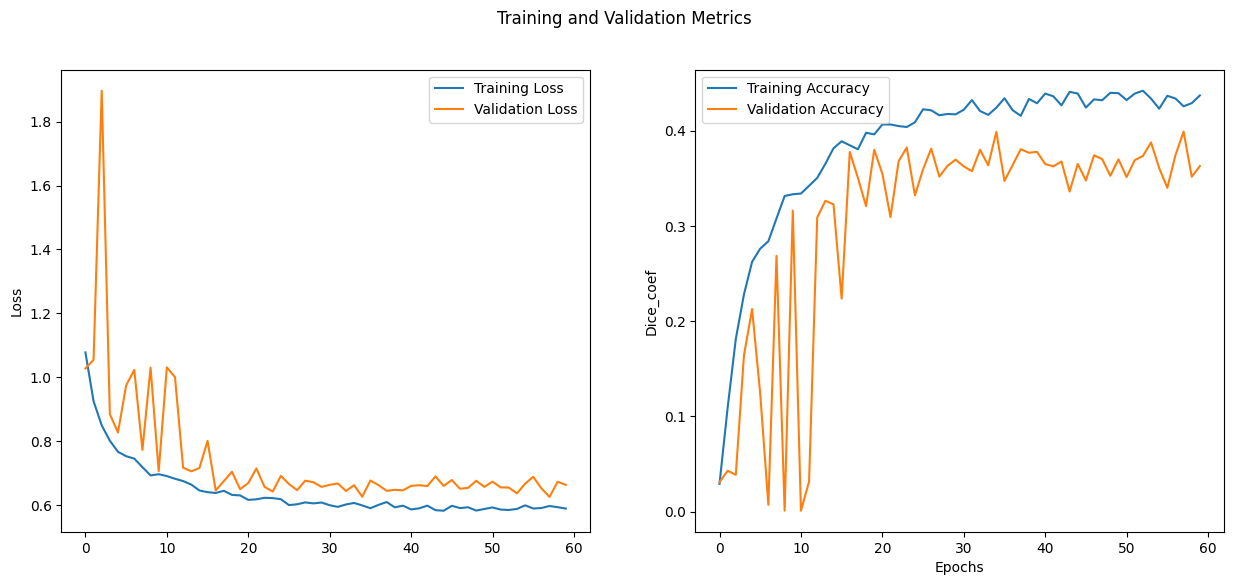

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 6))

# Plotting the training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting the training and validation accuracy
ax2.plot(history.history['dice_coef'], label='Training Accuracy')
ax2.plot(history.history['val_dice_coef'], label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Dice_coef')
ax2.legend()

plt.suptitle('Training and Validation Metrics')
plt.show()

1/1 [==============================] - 0s 410ms/step


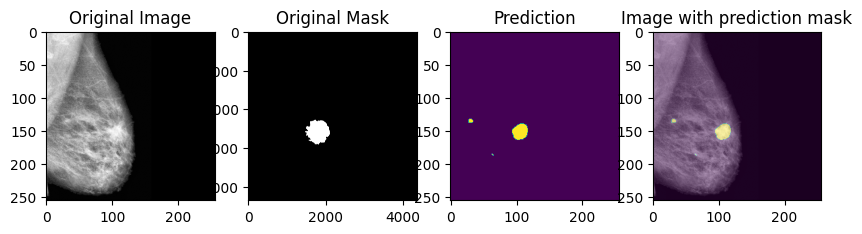

1/1 [==============================] - 0s 26ms/step


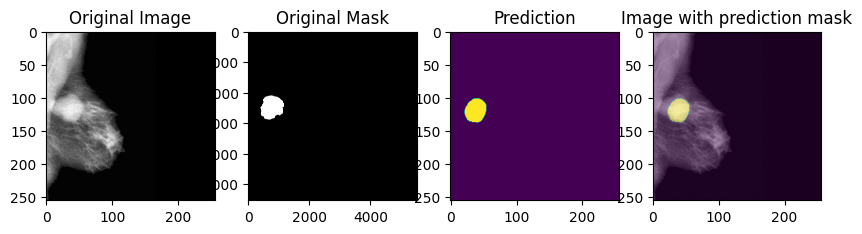

1/1 [==============================] - 0s 21ms/step


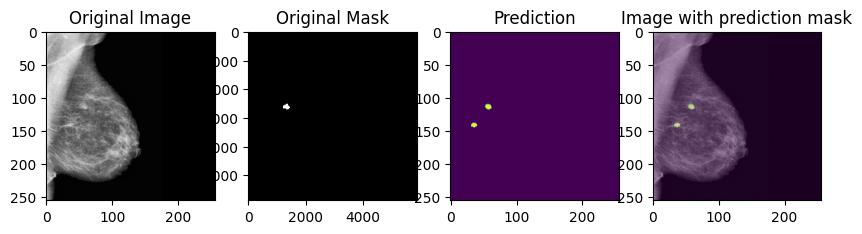

1/1 [==============================] - 0s 25ms/step


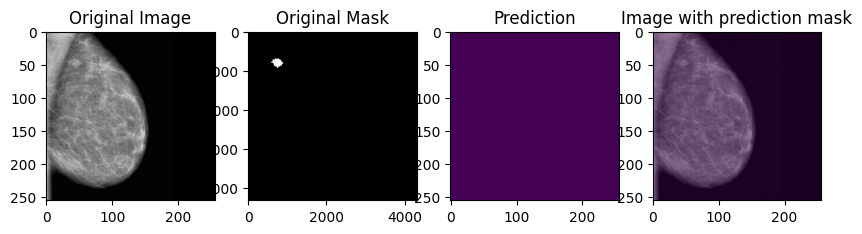

1/1 [==============================] - 0s 24ms/step


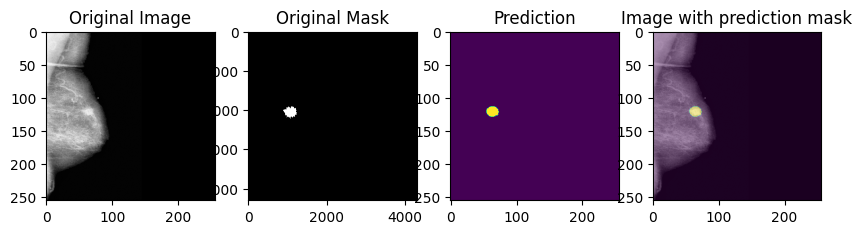

1/1 [==============================] - 0s 25ms/step


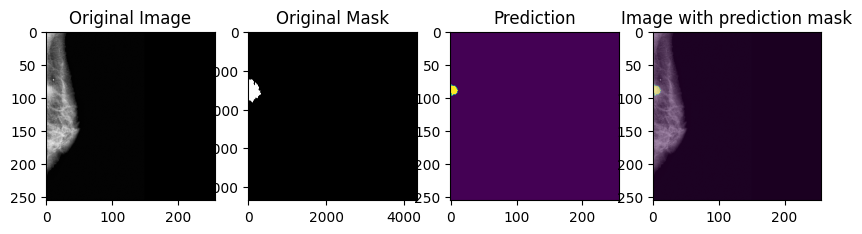

1/1 [==============================] - 0s 22ms/step


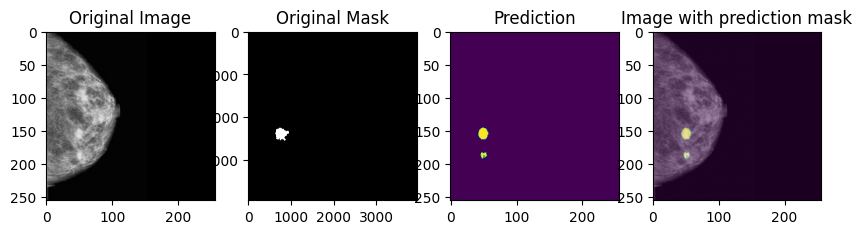

1/1 [==============================] - 0s 25ms/step


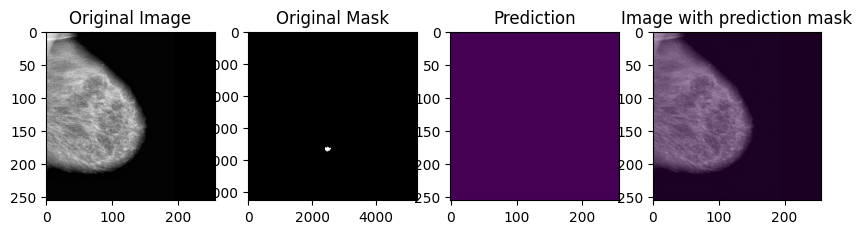

1/1 [==============================] - 0s 26ms/step


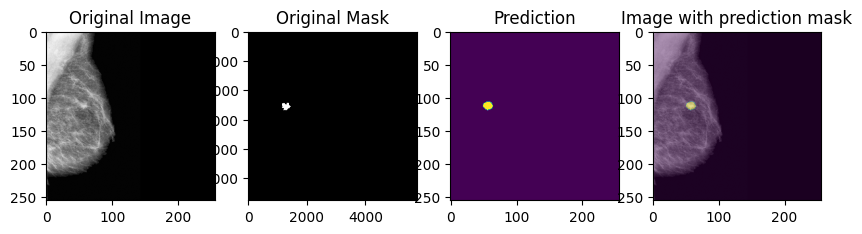

1/1 [==============================] - 0s 26ms/step


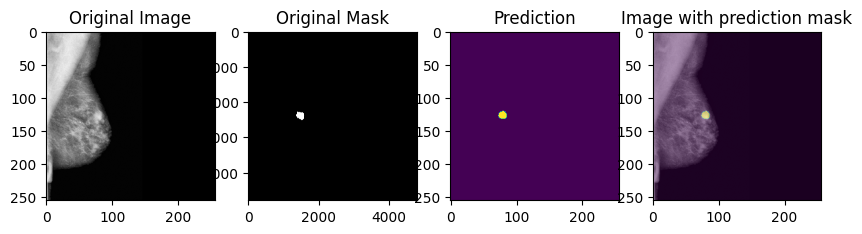

In [20]:
import cv2
for i in range(10):
    index=np.random.randint(1,len(data_test.index))
    img = cv2.imread(data_test['images'].iloc[index])
    img = cv2.resize(img ,(256, 256))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(data_test['masks'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(img))
    plt.imshow(np.squeeze(pred)>.5,alpha=0.4)
    plt.title('Image with prediction mask')
    plt.show()

In [21]:
model.save('unet.h5')